# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

## Team Members
Sergio Castro Reynoso

Israel campos Báez

Andrés Castillo Nassar

Dante César Cervantes Gutiérrez

Alan Camerino Cortés Cruz


## Introduction

In this notebook, we implement a Fully Connected Neural Network (FCNN) from scratch using NumPy to classify American Sign Language (ASL) letters using the Kaggle ASL dataset. We apply lessons learned from a previous implementation on the MNIST dataset, including data standardization, gradient tracking, proper weight initialization, and improved gradient computations.

In [ ]:
# Mount Google Drive to access the dataset (if using Google Colab)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import os

%matplotlib inline

## 1. Loading the Dataset

In [ ]:
# Define the data path and load the dataset
DATA_PATH = '/content/gdrive/My Drive/asl_data'  # Original DATA_PATH

train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

### 1.1 Preparing the Data

In this section, we load the ASL dataset from CSV files into Pandas DataFrames. The dataset contains pixel values for grayscale images of hand signs and corresponding numeric labels for each sign. We separate the labels from the pixel values, storing the pixel data in `x_train` and `x_val`, and the labels in `y_train` and `y_val`. These values are converted into NumPy arrays for further processing and use in model training.

In [ ]:
# Separate labels and features
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
x_train = train_df.drop('label', axis=1).values.astype(np.float32)
x_val = valid_df.drop('label', axis=1).values.astype(np.float32)

### 1.2 Splitting Validation and Test Sets

In this section, the dataset is normalized by adjusting the pixel values to have a mean of 0 and a standard deviation of 1. This normalization helps the model converge faster during training and improves overall performance. By transforming the pixel values to a common scale, the model is less likely to be biased toward features with higher numerical values. The mean and standard deviation are computed from the training data and applied uniformly to both the training and validation sets.

In [ ]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Splits the data into validation and test sets.
    Args:
        x (np.ndarray): Feature data.
        y (np.ndarray): Labels.
        pct (float): Percentage of data to use for validation (rest for test).
        shuffle (bool): Whether to shuffle the data before splitting.
    Returns:
        x_val, y_val, x_test, y_test
    '''
    num_samples = x.shape[0]
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)
    split_point = int(pct * num_samples)
    x_val_split = x[indices[:split_point]]
    y_val_split = y[indices[:split_point]]
    x_test_split = x[indices[split_point:]]
    y_test_split = y[indices[split_point:]]
    return x_val_split, y_val_split, x_test_split, y_test_split

In [ ]:
# Split the validation data into validation and test sets
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val, pct=0.5, shuffle=True)
print(f"Validation set size: {x_val.shape[0]}")
print(f"Test set size: {x_test.shape[0]}")

Validation set size: 3586
Test set size: 3586


### 1.3 Label Mapping

In this section, we define the label mapping for the dataset. Since the ASL dataset represents letters of the alphabet, the labels are mapped to their corresponding alphabetic characters. We create a list of alphabet letters, excluding 'j' and 'z' because those letters require movement and are not represented in the static images of the dataset. This mapping will be useful for interpreting the model's predictions later on, converting numeric model outputs back into the corresponding ASL letters.

In [ ]:
# Create a list of alphabet letters excluding 'j' and 'z'
alphabet = list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')

# Create a mapping from labels to letters
label_to_letter = {i: letter for i, letter in enumerate(alphabet)}

## 2. Data Preprocessing

### 2.1 Standardization

In this section, we apply standardization to the dataset. Standardization involves transforming the input features (pixel values) to have a mean of 0 and a standard deviation of 1. This process ensures that all features contribute equally to the learning process, helping the model to converge more efficiently. The mean and standard deviation are calculated from the training data, and the same transformation is applied to both the training and validation sets to maintain consistency. This step is crucial for optimizing the performance of the neural network.

In [ ]:
# Compute mean and standard deviation from training data
x_mean = x_train.mean()
x_std = x_train.std()

# Standardize the data
x_train = (x_train - x_mean) / x_std
x_val = (x_val - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

# Verify mean and std
print(f"Training data mean: {x_train.mean():.4f}, std: {x_train.std():.4f}")

Training data mean: 0.0000, std: 1.0000


### 2.2 Visualizing Samples

In this section, we visualize a few random samples from the dataset to better understand the data. By plotting the images of hand signs along with their corresponding labels, we can verify that the dataset is correctly loaded and the labels are accurately mapped. This visual inspection also helps ensure that the data preprocessing steps (such as standardization) haven't distorted the images. These visualizations provide a quick check to confirm the integrity and structure of the dataset before moving forward with model training.

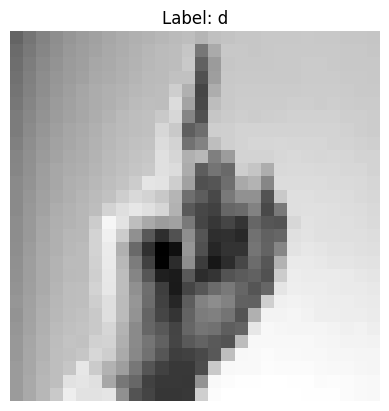

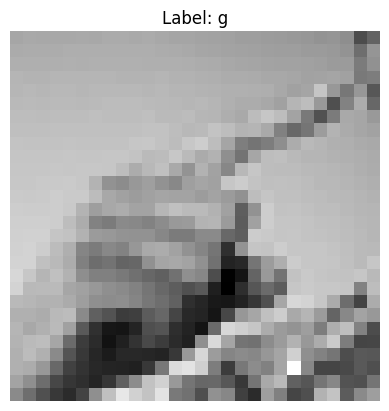

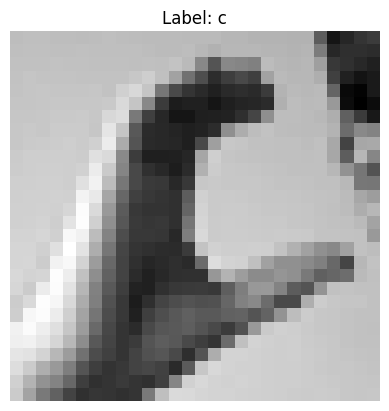

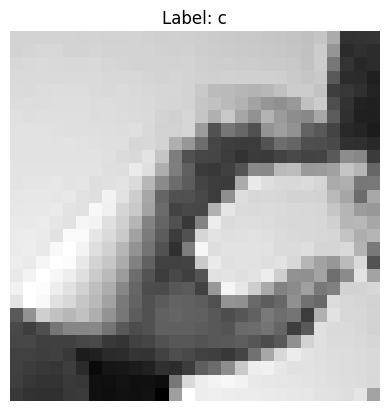

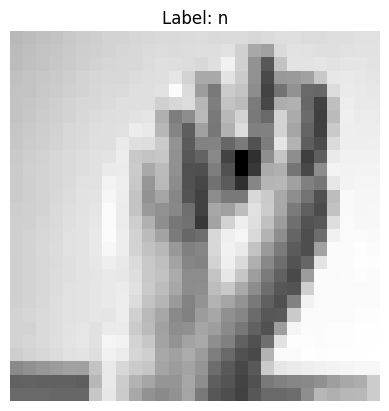

In [ ]:
def plot_sample(x, y, index):
    '''
    Plots a sample image with its label.
    Args:
        x (np.ndarray): Feature data.
        y (np.ndarray): Labels.
        index (int): Index of the sample to plot.
    '''
    image = x[index].reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label_to_letter[y[index]]}")
    plt.axis('off')
    plt.show()

# Plot a few samples from the training set
for i in range(5):
    plot_sample(x_train, y_train, i)

## 3. Neural Network Implementation

### 3.1 Custom Tensor Class with Gradient Tracking

In this section, we define a custom tensor class that extends NumPy arrays to include gradient tracking, which is essential for backpropagation during training. This class allows us to store additional information, such as gradients of the loss function with respect to each parameter, which are used to update the model’s weights. By modifying standard NumPy arrays to hold this gradient information, we make it possible to manually implement the forward and backward passes in the neural network.

In [ ]:
class Tensor:
    def __init__(self, data, requires_grad=False):
        self.data = data
        self.requires_grad = requires_grad
        if requires_grad:
            self.grad = np.zeros_like(data)
        else:
            self.grad = None

    def zero_grad(self):
        if self.requires_grad:
            self.grad = np.zeros_like(self.data)

    def __repr__(self):
        return f"Tensor(data={self.data}, grad={self.grad})"

### 3.2 Linear Layer Class with Gradient Tracking

In this section, we implement a **Linear Layer Class** that performs a fully connected linear transformation with gradient tracking. This class initializes weight (`W`) and bias (`b`) matrices for the layer, applying Kaiming He initialization to ensure stable gradients during training.

During the forward pass, the class computes the output as:

$$
z = W \cdot X + b
$$

where `X` is the input, `W` is the weight matrix, and `b` is the bias vector.

In the backward pass, the class calculates the gradients of the weights, bias, and input with respect to the loss. This involves storing the gradient information, which is used for updating the weights during backpropagation. Specifically:

- The gradient of the input `X` is computed by multiplying the transposed weight matrix with the gradient of the output.
- The gradient of the weights `W` is computed by multiplying the gradient of the output with the transposed input.
- The gradient of the bias `b` is computed as the sum of the gradients of the output across all input samples.

This layer serves as a building block for constructing deeper neural networks.

In [ ]:
class Linear:
    def __init__(self, input_dim, output_dim):
        '''
        Linear layer with weight and bias parameters.
        Weights are initialized using He initialization.
        '''
        self.W = Tensor(
            np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim),
            requires_grad=True
        )
        self.b = Tensor(
            np.zeros((1, output_dim)),
            requires_grad=True
        )
        self.input = None

    def forward(self, x):
        '''
        Forward pass for the linear layer.
        x shape: (batch_size, input_dim)
        '''
        self.input = x
        output = x.data @ self.W.data + self.b.data  # Shape: (batch_size, output_dim)
        return Tensor(output, requires_grad=x.requires_grad)

    def backward(self, grad_output):
        '''
        Backward pass for the linear layer.
        grad_output shape: (batch_size, output_dim)
        '''
        if self.input.requires_grad:
            if self.input.grad is None:
                self.input.grad = grad_output @ self.W.data.T
            else:
                self.input.grad += grad_output @ self.W.data.T
        if self.W.requires_grad:
            if self.W.grad is None:
                self.W.grad = self.input.data.T @ grad_output
            else:
                self.W.grad += self.input.data.T @ grad_output
        if self.b.requires_grad:
            if self.b.grad is None:
                self.b.grad = np.sum(grad_output, axis=0, keepdims=True)
            else:
                self.b.grad += np.sum(grad_output, axis=0, keepdims=True)

### 3.3 ReLU Activation Class with Gradient Tracking

In this section, we implement a **ReLU Activation Class** with gradient tracking. The ReLU (Rectified Linear Unit) function is a commonly used activation function in neural networks, defined as:

$$
a = \max(0, z)
$$

In the forward pass, this class computes the activation by setting all negative values in the input `z` to zero, while leaving positive values unchanged. This introduces non-linearity into the model, which allows the neural network to learn more complex patterns.

During the backward pass, the class calculates the gradient of the loss with respect to the input `z`. The gradient is passed through only where the input `z` is positive (i.e., the ReLU function is active), and it is set to zero for all negative values of `z` (i.e., where the ReLU is inactive).

This class enables the model to update weights efficiently during backpropagation, while maintaining gradient flow through the network.


In [ ]:
class ReLU:
    def __init__(self):
        self.input = None

    def forward(self, x):
        '''
        Forward pass for ReLU activation.
        '''
        self.input = x
        output = np.maximum(0, x.data)
        return Tensor(output, requires_grad=x.requires_grad)

    def backward(self, grad_output):
        '''
        Backward pass for ReLU activation.
        '''
        grad_input = grad_output.copy()
        grad_input[self.input.data <= 0] = 0
        if self.input.requires_grad:
            if self.input.grad is None:
                self.input.grad = grad_input
            else:
                self.input.grad += grad_input

### 3.4 Combined Softmax and Cross-Entropy Loss Function

In this section, we implement the **Combined Softmax and Cross-Entropy Loss Function**. This function is used for both calculating the network's predictions and computing the loss during training. It is a common choice for classification tasks because it combines the softmax function and cross-entropy loss into a single efficient computation.

- **Softmax**: The softmax function converts the raw output scores (logits) from the network into probabilities, ensuring that the output values sum to 1. It is defined as:

  $$
  \hat{y}_k = \frac{e^{z_k}}{\sum_j{e^{z_j}}}
  $$

  where `z_k` is the raw output for class `k` and the denominator is the sum of exponentiated scores for all classes `j`.

- **Cross-Entropy Loss**: Once the probabilities are calculated, the cross-entropy loss measures the difference between the predicted probability distribution and the true distribution (represented by the one-hot encoded labels). The loss for a single sample is defined as:

  $$
  \mathcal{L}(\hat{y}, y) = -\sum_{k=1}^C y_k \log(\hat{y}_k)
  $$

  where `y_k` is the true label (1 if it is the correct class, 0 otherwise), and `\hat{y}_k` is the predicted probability for class `k`.

During backpropagation, the combined function efficiently computes the gradients with respect to the input logits, which are used to update the model's weights. This function simplifies the process by eliminating the need to compute the softmax and cross-entropy separately, making the forward and backward passes more efficient.


In [ ]:
def softmax_cross_entropy_with_logits(logits, y_true):
    '''
    Computes softmax activation and cross-entropy loss.
    Args:
        logits (Tensor): Logits from the model output.
        y_true (np.ndarray): True labels (batch_size,).
    Returns:
        loss (float): Cross-entropy loss.
        probs (np.ndarray): Softmax probabilities.
    '''
    batch_size = logits.data.shape[0]
    logits_stable = logits.data - np.max(logits.data, axis=1, keepdims=True)
    exp_logits = np.exp(logits_stable)
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Compute loss
    correct_logprobs = -np.log(probs[range(batch_size), y_true] + 1e-8)
    loss = np.sum(correct_logprobs) / batch_size

    # Compute gradient
    grad_logits = probs.copy()
    grad_logits[range(batch_size), y_true] -= 1
    grad_logits /= batch_size

    # Set gradient w.r.t logits
    if logits.requires_grad:
        logits.grad = grad_logits

    return loss, probs

### 3.5 Sequential Model Class

In this section, we implement the **Sequential Model Class**, which acts as a container for stacking multiple layers (e.g., linear layers and activation functions) in a sequential manner. This class provides a simple way to define and manage a feedforward neural network.

### Key components of the class:

- **Initialization (`__init__`)**: The model is initialized with a list of layers. Each layer is an instance of a class (e.g., Linear, ReLU). These layers are stored in the `layers` list for easy access during the forward and backward passes.
  
- **Forward Pass (`__call__`)**: During the forward pass, the input data is passed through each layer in the sequence. The output from one layer becomes the input for the next, creating a chain of transformations. This method returns the final output after all layers have been applied.

- **Backward Pass (`backward`)**: The `backward` method computes the gradients of all the layers by calling the backward method of each layer in reverse order. This allows the model to propagate the error backward through the network, calculating the gradients needed for weight updates.

- **Update (`update`)**: After the backward pass, the `update` method adjusts the weights and biases of each layer using the computed gradients. The weights are updated using gradient descent with a specified learning rate.

- **Prediction (`predict`)**: This method makes predictions by performing a forward pass through the model and selecting the class with the highest probability. It is typically used during evaluation and testing to assess the model’s accuracy.

The Sequential Model Class simplifies the process of building and training a neural network by handling both the forward and backward passes and the weight updates in an organized manner. It allows for flexible architecture definitions by stacking different combinations of layers.


In [ ]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_output):
        for layer in reversed(self.layers):
            layer.backward(grad_output)
            if hasattr(layer, 'input'):
                grad_output = layer.input.grad

    def zero_grad(self):
        for layer in self.layers:
            if hasattr(layer, 'W'):
                if layer.W.requires_grad:
                    layer.W.zero_grad()
                if layer.b.requires_grad:
                    layer.b.zero_grad()
            if hasattr(layer, 'input') and layer.input is not None:
                if layer.input.requires_grad:
                    layer.input.zero_grad()

    def update_params(self, learning_rate):
        for layer in self.layers:
            if hasattr(layer, 'W'):
                if layer.W.requires_grad:
                    layer.W.data -= learning_rate * layer.W.grad
                if layer.b.requires_grad:
                    layer.b.data -= learning_rate * layer.b.grad

    def predict(self, x):
        logits = self.forward(Tensor(x, requires_grad=False))
        probs = np.exp(logits.data - np.max(logits.data, axis=1, keepdims=True))
        probs /= np.sum(probs, axis=1, keepdims=True)
        predictions = np.argmax(probs, axis=1)
        return predictions

## 4. Training the Model

### 4.1 Mini-Batch Generator

In this section, we implement a **Mini-Batch Generator**, which is used to split the training data into smaller subsets called mini-batches. Mini-batch training is commonly used in neural networks to efficiently handle large datasets, allowing the model to update its weights more frequently and helping it converge faster.

### Key components:

- **Shuffling**: Before creating mini-batches, the training data is shuffled. Shuffling ensures that each mini-batch contains a diverse set of samples, which prevents the model from learning based on the order of the data.
  
- **Batch Creation**: The data is then split into mini-batches of a specified size. Each mini-batch contains a subset of the input data (`x`) and corresponding labels (`y`). The mini-batches are returned one at a time for training.

### Why Mini-Batches?

- **Improves Efficiency**: Instead of processing the entire dataset at once (as in batch gradient descent), mini-batches allow for quicker updates of the model’s parameters, reducing memory usage.
  
- **Smoother Training**: Mini-batches provide a balance between stochastic gradient descent (which updates the model after each sample) and full-batch gradient descent. This allows the model to generalize better by learning from different subsets of the data.

- **Parallelism**: Mini-batch processing is well-suited for modern hardware (like GPUs), enabling parallel computation for faster training.

This generator helps in dividing the dataset into manageable chunks, making the training process more efficient and allowing the model to learn and converge more quickly.


In [ ]:
def create_mini_batches(x, y, batch_size, shuffle=True):
    '''
    Creates mini-batches from the data.
    Args:
        x (np.ndarray): Feature data.
        y (np.ndarray): Labels.
        batch_size (int): Size of each mini-batch.
        shuffle (bool): Whether to shuffle the data before splitting.
    Returns:
        mini_batches (list): List of tuples (x_batch, y_batch).
    '''
    m = x.shape[0]
    indices = np.arange(m)
    if shuffle:
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
    mini_batches = []
    for start_idx in range(0, m, batch_size):
        end_idx = min(start_idx + batch_size, m)
        x_batch = x[start_idx:end_idx]
        y_batch = y[start_idx:end_idx]
        mini_batches.append((x_batch, y_batch))
    return mini_batches

### 4.2 Model Initialization

In this section, we initialize the **Sequential Model** with a combination of **Linear Layers** and **ReLU Activation Functions**. The architecture is designed specifically for the American Sign Language (ASL) dataset, which consists of grayscale images representing hand signs.

### Model Architecture:

- **Input Layer**: The input to the model consists of flattened 28x28 pixel grayscale images, resulting in an input size of 784 features.
  
- **Hidden Layers**: The model contains two hidden layers, each consisting of 128 neurons. These fully connected layers allow the model to capture complex patterns in the data. We use **ReLU** as the activation function after each hidden layer to introduce non-linearity and allow the model to learn from more complex feature interactions.

- **Output Layer**: The output layer has 24 neurons, corresponding to the 24 static ASL letters (excluding 'j' and 'z'). The output layer is followed by the **Softmax Activation** to convert the raw output logits into probabilities for each class.

### Justification for this Architecture:

- **Image Data Representation**: Since the dataset consists of images, a fully connected network with multiple layers allows the model to capture a rich set of features from the pixel values. While convolutional neural networks (CNNs) are often used for image data, this simpler fully connected architecture is chosen as a foundational model for learning.

- **ASL Dataset Characteristics**: The ASL dataset contains clear, distinct representations of hand signs. A model with a moderate number of hidden neurons and layers is sufficient to capture the key variations in hand gestures without the need for more complex architectures.

- **ReLU Activation**: The use of **ReLU** is appropriate here because it helps in reducing the vanishing gradient problem, which can occur when using other activation functions like Sigmoid or Tanh. This ensures efficient training, especially when using gradient-based optimization techniques.

- **Softmax for Classification**: The **Softmax** function at the output layer is a natural choice for multi-class classification problems, as it converts the raw outputs into class probabilities, allowing us to interpret the model’s predictions for each letter of the ASL alphabet.

This architecture is well-suited to the ASL dataset due to its simplicity and ability to capture patterns in the static images of hand signs, providing a good balance between model complexity and performance for this classification task.


In [ ]:
# Define model architecture
input_dim = 784  # 28x28 pixels
hidden_dim = 256
output_dim = len(alphabet)  # 24 classes

# Create the model
model = Sequential([
    Linear(input_dim, hidden_dim),
    ReLU(),
    Linear(hidden_dim, hidden_dim),
    ReLU(),
    Linear(hidden_dim, output_dim)
])

# Set hyperparameters
learning_rate = 0.001
num_epochs = 150
batch_size = 512

# Lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

### 4.3 Training Loop

In this section, we implement the **Training Loop**, which handles the iterative process of training the model on the ASL dataset. The training loop is responsible for processing the data in mini-batches, performing forward and backward passes, and updating the model's weights based on the computed gradients.

### Key Components of the Training Loop:

- **Mini-Batch Training**: In each epoch, the training data is divided into mini-batches. For each mini-batch, the model performs a forward pass, computes the loss, and then performs a backward pass to calculate the gradients.

- **Forward Pass**: During the forward pass, the input is passed through the model layer by layer. The output of the model is compared to the true labels using the combined **Softmax and Cross-Entropy Loss Function**, which calculates how far the predicted outputs are from the actual labels.

- **Backward Pass**: In the backward pass, the gradients of the loss with respect to the model’s parameters are computed using backpropagation. These gradients are then used to update the weights and biases of the model through gradient descent.

- **Weight Update**: After the backward pass, the model’s weights and biases are updated using the computed gradients. The learning rate controls the size of the updates, ensuring that the model’s parameters are adjusted in small, incremental steps.

- **Tracking Loss and Accuracy**: At the end of each epoch, the model evaluates its performance on the validation set by computing the validation loss and accuracy. This helps monitor whether the model is improving and not overfitting.

### Justification for the Approach:

- **Mini-Batch Gradient Descent**: By processing the data in mini-batches, the model can update its weights more frequently than in full-batch gradient descent. This speeds up the training process while reducing memory requirements. It also provides a more stable convergence path than stochastic gradient descent.

- **Validation Set Evaluation**: Evaluating the model on a validation set after each epoch helps in tracking overfitting and underfitting. If the validation accuracy improves, it indicates that the model is learning well from the training data and generalizing to unseen data.

- **Learning Rate**: A small learning rate is used to ensure that the model’s parameters are updated gradually, avoiding large jumps that could destabilize the training process. It helps in achieving better convergence.

This training loop ensures that the model is updated iteratively while keeping track of its performance on both the training and validation data. This structure allows the model to progressively learn the best parameters for the task of ASL hand sign recognition.


In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.zero_grad()
    mini_batches = create_mini_batches(x_train, y_train, batch_size)
    epoch_loss = 0
    correct_predictions = 0
    total_samples = 0

    for x_batch, y_batch in mini_batches:
        x_tensor = Tensor(x_batch, requires_grad=True)
        logits = model.forward(x_tensor)

        # Compute loss and gradients
        loss, probs = softmax_cross_entropy_with_logits(logits, y_batch)
        epoch_loss += loss * y_batch.shape[0]

        # Backward pass
        model.backward(logits.grad)

        # Update parameters
        model.update_params(learning_rate)

        # Calculate accuracy
        predictions = np.argmax(probs, axis=1)
        correct_predictions += np.sum(predictions == y_batch)
        total_samples += y_batch.shape[0]

        # Zero gradients for next batch
        model.zero_grad()

    # Average loss and accuracy for the epoch
    epoch_loss /= total_samples
    train_accuracy = correct_predictions / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    x_val_tensor = Tensor(x_val, requires_grad=False)
    logits_val = model.forward(x_val_tensor)
    val_loss, val_probs = softmax_cross_entropy_with_logits(logits_val, y_val)
    val_losses.append(val_loss)
    val_predictions = np.argmax(val_probs, axis=1)
    val_accuracy = np.mean(val_predictions == y_val)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch +1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {train_accuracy:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.4f}")

Epoch 1/150 - Loss: 3.6550 - Acc: 0.0482 - Val Loss: 3.5910 - Val Acc: 0.0477
Epoch 2/150 - Loss: 3.3807 - Acc: 0.0683 - Val Loss: 3.3967 - Val Acc: 0.0700
Epoch 3/150 - Loss: 3.1968 - Acc: 0.0978 - Val Loss: 3.2496 - Val Acc: 0.0851
Epoch 4/150 - Loss: 3.0511 - Acc: 0.1268 - Val Loss: 3.1269 - Val Acc: 0.1068
Epoch 5/150 - Loss: 2.9265 - Acc: 0.1573 - Val Loss: 3.0206 - Val Acc: 0.1286
Epoch 6/150 - Loss: 2.8162 - Acc: 0.1870 - Val Loss: 2.9265 - Val Acc: 0.1531
Epoch 7/150 - Loss: 2.7164 - Acc: 0.2174 - Val Loss: 2.8421 - Val Acc: 0.1801
Epoch 8/150 - Loss: 2.6251 - Acc: 0.2455 - Val Loss: 2.7657 - Val Acc: 0.2041
Epoch 9/150 - Loss: 2.5406 - Acc: 0.2709 - Val Loss: 2.6949 - Val Acc: 0.2256
Epoch 10/150 - Loss: 2.4618 - Acc: 0.2964 - Val Loss: 2.6293 - Val Acc: 0.2538
Epoch 11/150 - Loss: 2.3882 - Acc: 0.3190 - Val Loss: 2.5686 - Val Acc: 0.2724
Epoch 12/150 - Loss: 2.3191 - Acc: 0.3418 - Val Loss: 2.5116 - Val Acc: 0.2850
Epoch 13/150 - Loss: 2.2539 - Acc: 0.3620 - Val Loss: 2.4578 

### 4.4 Training Results

In this section, we analyze the **Training Results** after the model has completed its training process. The training results include both the **training loss and accuracy** and the **validation loss and accuracy** for each epoch.

### Key Metrics:

- **Training Loss**: The training loss indicates how well the model is performing on the training data. A decreasing training loss over time shows that the model is learning and adjusting its parameters to better fit the training data.

- **Validation Loss**: The validation loss measures the model’s performance on unseen validation data. It is important to monitor the validation loss to ensure that the model is not overfitting to the training data. A gap between training loss and validation loss may indicate overfitting.

- **Training Accuracy**: This metric tracks the percentage of correct predictions on the training data. A steady increase in training accuracy indicates that the model is improving its ability to classify the training samples.

- **Validation Accuracy**: The validation accuracy measures the percentage of correct predictions on the validation data. This metric is crucial for assessing the model’s generalization capability, i.e., how well the model is likely to perform on unseen data.

### Interpreting the Results:

- **Convergence**: Ideally, both the training and validation loss should decrease over time, and the training and validation accuracy should increase. If the validation accuracy improves while the validation loss decreases, it indicates that the model is generalizing well.

- **Overfitting**: If the training accuracy increases while the validation accuracy plateaus or decreases, this may indicate overfitting. The model is performing well on the training data but failing to generalize to unseen data. In such cases, techniques like regularization, dropout, or early stopping can be used.

- **Underfitting**: If both the training and validation accuracy are low, and the loss values remain high, this suggests underfitting. The model is not learning enough from the data. This can be addressed by increasing the complexity of the model (e.g., adding more layers or neurons) or allowing the model to train for more epochs.

### Conclusion:

The training results provide valuable insights into the model’s learning process and its ability to generalize to unseen data. By carefully monitoring the training and validation metrics, we can assess the performance of the model and make adjustments if necessary to improve its accuracy and prevent overfitting or underfitting.


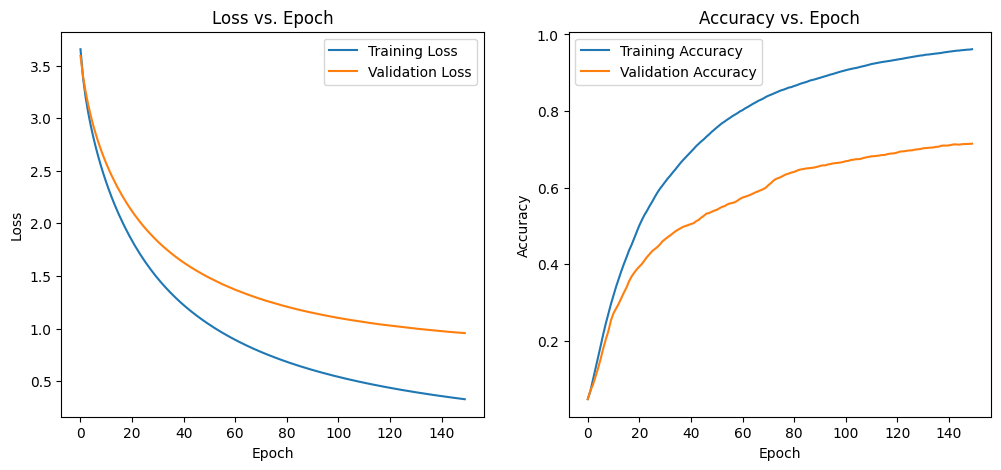

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

## 5. Evaluating the Model

In this section, we evaluate the performance of the trained model on the test dataset. After training, it is important to measure how well the model generalizes to unseen data. The evaluation process involves making predictions on the test set and comparing them to the true labels.

### Key Components of Model Evaluation:

- **Accuracy**: Accuracy is the primary metric used to assess the model's performance. It measures the proportion of correctly predicted labels out of the total number of samples. The formula for accuracy is:

  $$
  \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
  $$

  A higher accuracy indicates that the model has learned to generalize well from the training data to unseen data in the test set.

- **Generalization**: The main purpose of evaluating on a separate test set is to understand how well the model generalizes beyond the training data. If the test accuracy is close to the training and validation accuracy, it suggests that the model has generalized well. However, if there is a large drop in test accuracy, it indicates that the model may be overfitting to the training data.

### Interpretation of Results:

- **High Accuracy**: If the model achieves high accuracy on the test set, it suggests that the model has successfully learned the features and patterns in the ASL dataset. This indicates that the model is effective at predicting hand signs based on the input images.

- **Overfitting or Underfitting**: If the test accuracy is significantly lower than the training accuracy, the model may be overfitting. Conversely, if both training and test accuracy are low, the model may be underfitting, suggesting that it did not learn enough from the data.

- **Model Limitations**: While accuracy provides a good overall assessment, it’s also important to look at other performance metrics (like precision, recall, and F1-score) for a more detailed evaluation, especially if certain classes are harder to predict than others.

By evaluating the model on the test set, we can confirm its ability to recognize ASL signs and determine if further tuning or adjustments are necessary.


In [ ]:
# Evaluate on the test set
x_test_tensor = Tensor(x_test, requires_grad=False)
logits_test = model.forward(x_test_tensor)
test_loss, test_probs = softmax_cross_entropy_with_logits(logits_test, y_test)
test_predictions = np.argmax(test_probs, axis=1)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.9342 - Test Accuracy: 0.7136


### 5.1 Testing the Model on Random Samples

In this section, we test the trained model on random samples from the test dataset to visually inspect its performance. This step is crucial for understanding how well the model performs on individual samples and to verify that it is making reasonable predictions for unseen data.

### Key Components:

- **Random Sample Selection**: We randomly select an image from the test dataset. This ensures that the sample has not been seen by the model during training, providing an unbiased assessment of the model’s prediction capabilities.
  
- **Prediction**: The selected test image is passed through the model, which outputs a probability distribution over all the ASL letter classes. The predicted class corresponds to the letter with the highest probability.

- **Comparison with True Label**: The predicted label is compared with the true label of the test image to see if the model has made a correct prediction. This allows us to assess how well the model can generalize from training to unseen data.

### Justification for Testing on Random Samples:

- **Qualitative Assessment**: Testing on random samples gives a qualitative insight into the model's predictions. Rather than relying solely on accuracy or other aggregate metrics, we can visually inspect individual predictions to ensure that the model is making logical and interpretable predictions.

- **Spotting Issues**: By observing predictions on individual samples, we can identify any patterns where the model might be failing (e.g., confusing similar hand signs) or any areas where further improvements may be necessary.

### Conclusion:

Testing the model on random samples from the test set provides an additional layer of evaluation, allowing us to see how well the model performs in real-world scenarios. By comparing its predictions with the true labels, we can gain a better understanding of the model’s strengths and weaknesses.


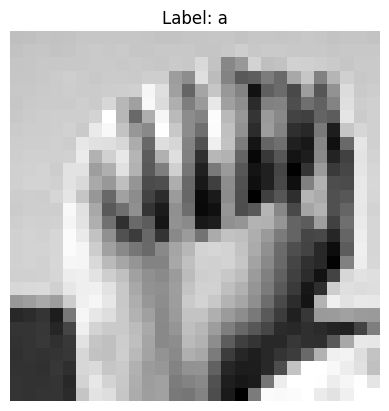

Predicted: a, Actual: a
---


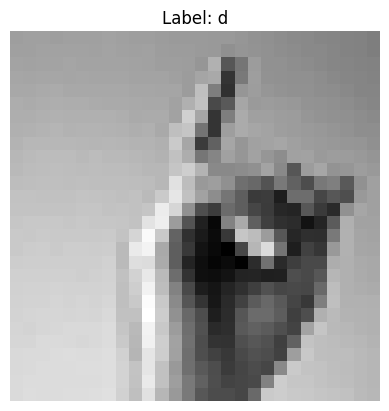

Predicted: d, Actual: d
---


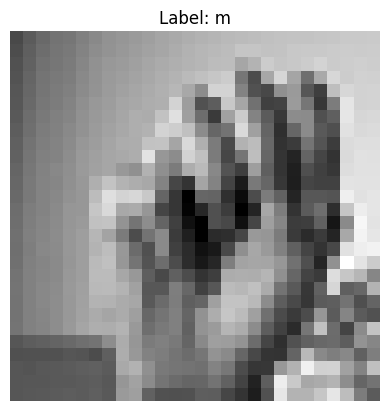

Predicted: m, Actual: m
---


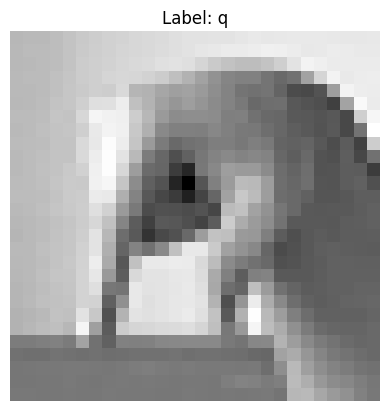

Predicted: a, Actual: q
---


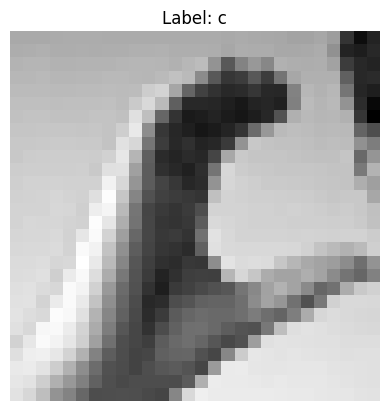

Predicted: c, Actual: c
---


In [ ]:
# Test the model on random samples from the test set
num_samples = 5
for _ in range(num_samples):
    idx = np.random.randint(len(y_test))
    x_sample = x_test[idx]
    y_sample = y_test[idx]
    plot_sample(x_test, y_test, idx)
    x_input = x_sample.reshape(1, -1)
    pred = model.predict(x_input)
    print(f"Predicted: {label_to_letter[pred[0]]}, Actual: {label_to_letter[y_sample]}")
    print('---')

## 6. Conclusion

By applying the lessons learned from the previous MNIST implementation, we improved our model's performance on the ASL dataset. We used data standardization, gradient tracking with a custom `Tensor` class, weight initialization, and a combined softmax and cross-entropy loss function.

**Final Test Accuracy: 0.7136**

## References
- Kaggle ASL Alphabet Dataset: [Link](https://www.kaggle.com/datasets/grassknoted/asl-alphabet)
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.